## 高斯网络模型
### 一、文本数据

In [1]:
import pandas as pd
import numpy as np
from sklearn.covariance import GraphicalLasso,GraphicalLassoCV
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import matplotlib as mpl
import akshare as ak

In [2]:
data=pd.read_csv('/Users/singal/Desktop/论文/数据/每日每条评论的情感得分-超大样本-对齐日期.csv')
data=data.astype({'index':'string','score':float})

data['index'][data['index']=='2142']='002142'#csv文件将'002142'当作'2142'处理
data['index'][data['index']=='1']='000001'#csv文件将'000001'当作'1'处理

data=data.set_index(['index','date'])
data

title     score
index  date                                             
601398 2月12日          指数上涨≠赚钱效应，这两个板块虎年一定会出大牛股  0.384621
       2月14日   $工商银行(SH601398)$做股票不要听别人扯蛋，跟着自己  0.360544
       2月14日  $工商银行(SH601398)$1.短期俄乌局势紧张无法缓解，大  0.302047
       2月14日                         拉起来！这是命令！  0.351310
       2月14日         垃圾股，跌起来比谁都快，一毛钱一毛钱的跌，涨起来就  0.387783
...                                        ...       ...
601009 2月26日                 想不通这个价位居然有人想进，还满仓  0.361342
       2月26日                      为啥南京银行利润率这么高  0.354323
       2月26日                             坐等便宜货  0.390895
       2月26日                        满仓干就是，增长好股  0.351868
       2月26日                 辛丑牛年上证综指能否打破27年魔咒  0.373960

[313350 rows x 2 columns]

In [3]:
lis=[]#去除index,date中的重复元素
for i in list(data.index):
    if i not in lis:
        lis.append(i)
lis[:10]

[('601398', '2月12日'),
 ('601398', '2月14日'),
 ('601398', '2月13日'),
 ('601398', '2月11日'),
 ('601398', '2月10日'),
 ('601398', '2月9日'),
 ('601398', '2月8日'),
 ('601398', '2月7日'),
 ('601398', '2月6日'),
 ('601398', '2月5日')]

In [4]:
lis_score=[]#计算每日均分
for i in lis:
    index,date=i
    daily_score=data.loc[index,date]['score'].mean()
    lis_score.append([index,date,daily_score])

daily_data=pd.DataFrame(lis_score,columns=['index','date','daily_score'])
daily_data=daily_data.set_index(['index','date'])
daily_data

daily_score
index  date              
601398 2月12日     0.333146
       2月14日     0.343979
       2月13日     0.356835
       2月11日     0.340108
       2月10日     0.338880
...                   ...
601009 3月2日      0.349153
       3月1日      0.347498
       2月28日     0.352824
       2月27日     0.331138
       2月26日     0.367904

[7003 rows x 1 columns]

In [5]:
names=['工商银行','建设银行','农业银行','中国银行','邮储银行','交通银行','招商银行','浦发银行','兴业银行','中信银行','民生银行','光大银行','平安银行','华夏银行','北京银行','上海银行','江苏银行','浙商银行','宁波银行','南京银行']

symbols=['601398','601939','601288','601988','601658','601328','600036','600000','601166','601998','600016','601818','000001','600015','601169','601229','600919','601916','002142','601009']

describe=pd.DataFrame()
for i in range(len(symbols)):
    describe[names[i]]=daily_data.loc[symbols[i]].describe()

In [6]:
describe.iloc[:,10:]

,民生银行,光大银行,平安银行,华夏银行,北京银行,上海银行,江苏银行,浙商银行,宁波银行,南京银行
count,351.000000,350.000000,351.000000,350.000000,351.000000,345.000000,350.000000,351.000000,350.000000,348.000000
mean,0.351292,0.351981,0.355598,0.347333,0.345924,0.344278,0.348264,0.351704,0.351115,0.350455
std,0.006811,0.010158,0.009876,0.011895,0.008211,0.013669,0.012862,0.012138,0.013659,0.013180
min,0.333106,0.317294,0.316409,0.294743,0.303369,0.286975,0.301570,0.299641,0.298717,0.310068
25%,0.346756,0.346741,0.350579,0.340940,0.341984,0.337686,0.341075,0.345432,0.343226,0.343056
50%,0.351209,0.351873,0.356499,0.347656,0.346439,0.345168,0.349525,0.352425,0.352221,0.350220
75%,0.355043,0.357150,0.361038,0.354686,0.350976,0.352574,0.356292,0.358948,0.359021,0.357611
max,0.376948,0.409566,0.403980,0.380536,0.371682,0.384939,0.393485,0.381082,0.404200,0.392993


In [7]:
df2=daily_data.loc['601398'].reset_index()
for symbol in symbols[1:]:
    df1=daily_data.loc[symbol].reset_index()
    df2=pd.merge(df2,df1,on='date')

df2

,date,daily_score_x,daily_score_y,daily_score_x,daily_score_y,daily_score_x,daily_score_y,daily_score_x,daily_score_y,daily_score_x,...,daily_score_x,daily_score_y,daily_score_x,daily_score_y,daily_score_x,daily_score_y,daily_score_x,daily_score_y,daily_score_x,daily_score_y
0,2月12日,0.333146,0.322967,0.326229,0.325340,0.315491,0.341910,0.327039,0.331976,0.336458,...,0.339223,0.326691,0.338148,0.324650,0.348231,0.322651,0.316819,0.331842,0.327783,0.358514
1,2月14日,0.343979,0.341454,0.344826,0.339380,0.342920,0.345991,0.338359,0.359238,0.349111,...,0.350574,0.339642,0.347771,0.349682,0.331901,0.335491,0.348175,0.367062,0.340222,0.341217
2,2月13日,0.356835,0.325907,0.345732,0.327788,0.329451,0.346556,0.340473,0.346384,0.333994,...,0.333849,0.322147,0.358164,0.343615,0.324727,0.338988,0.335154,0.357101,0.337750,0.342269
3,2月11日,0.340108,0.333593,0.348766,0.349395,0.333117,0.340235,0.337098,0.345962,0.340515,...,0.350536,0.351557,0.343327,0.323629,0.343776,0.330312,0.336563,0.345142,0.346444,0.340166
4,2月10日,0.338880,0.349574,0.347763,0.330955,0.329754,0.338252,0.340947,0.362832,0.336359,...,0.346287,0.338971,0.343557,0.335238,0.336674,0.345726,0.336755,0.345473,0.348689,0.347340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327,3月5日,0.343918,0.341321,0.351551,0.352734,0.369340,0.345797,0.359210,0.348633,0.352137,...,0.342660,0.348832,0.350579,0.353857,0.342144,0.350281,0.361750,0.365615,0.362865,0.361199
328,3月4日,0.353508,0.356645,0.353772,0.350353,0.346001,0.358478,0.346232,0.339555,0.358789,...,0.350460,0.340039,0.347254,0.368290,0.349026,0.351964,0.332413,0.348092,0.364861,0.349940
329,3月3日,0.345622,0.350507,0.355939,0.353543,0.346332,0.358471,0.345123,0.348002,0.354589,...,0.345176,0.345659,0.353144,0.342080,0.352578,0.349670,0.356870,0.356297,0.350285,0.350333
330,3月2日,0.360315,0.356589,0.347061,0.356152,0.356680,0.351494,0.352914,0.348598,0.360469,...,0.350167,0.349711,0.358219,0.347100,0.347079,0.339454,0.337779,0.366387,0.375389,0.349153


In [8]:
def estimateCV(X):#使用交叉验证确定精度矩阵的超参数
    model=GraphicalLassoCV(alphas=5,cv=10)
    model.fit(X)

    pre=model.precision_
    cov=model.covariance_
    score=model.cv_results_['mean_test_score'].mean()
    
    return pre,cov,score
    
def estimate(X):#不使用交叉验证
    model=GraphicalLasso()
    model.fit(X)

    pre=model.precision_
    cov=model.covariance_

    return pre,cov

def calCor(p_matrix):#根据精度矩阵计算相关系数矩阵
    n=len(p_matrix)
    cor_matrix=np.zeros((n,n))

    for i in range(n):
        for j in range(n):
            cor_matrix[i][j]=p_matrix[i][j]/np.sqrt(p_matrix[i][i]*p_matrix[j][j])

    return cor_matrix

In [9]:
X_text=df2.iloc[:,1:]
X_text.columns=symbols
X_text=X_text*100
pre_text,cov_text=estimate(X_text)
cor_text=calCor(pre_text)
pre_cv_text,cov_cv_text,score_text=estimateCV(X_text)
cor_cv_text=calCor(pre_cv_text)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


<AxesSubplot:>

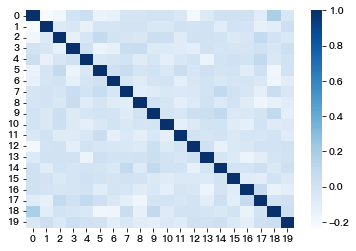

In [10]:
sns.heatmap(cor_text,cmap='Blues')

<AxesSubplot:>

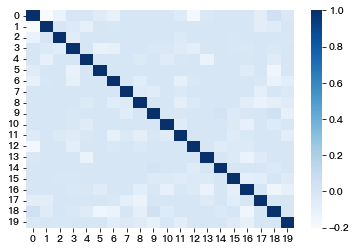

In [11]:
sns.heatmap(cor_cv_text,cmap='Blues')

### 二、市场数据

In [12]:
data=pd.read_csv('./数据/市场数据.csv')
X_market=data.iloc[:,1:].dropna()
X_market=X_market*100
pre_market,cov_market=estimate(X_market)
cor_market=calCor(pre_market)
pre_cv_market,cov_cv_market,score_market=estimateCV(X_market)
cor_cv_market=calCor(pre_cv_market)

<AxesSubplot:>

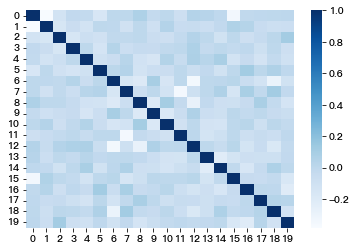

In [13]:
sns.heatmap(cor_market,cmap='Blues')

<AxesSubplot:>

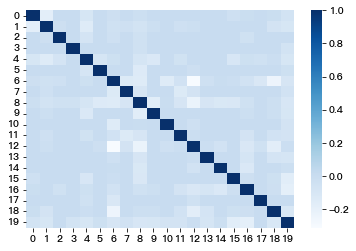

In [14]:
sns.heatmap(cor_cv_market,cmap='Blues')

### 三、CoVaR
#### 1、静态CoVaR
静态CoVaR只做尝试，不出现于论文部分。

In [15]:
import statsmodels.api as sm
data_loss=pd.read_csv('./数据/动态风险数据.csv')
X_y=data_loss.set_index('日期')

from sklearn.impute import KNNImputer
model=KNNImputer(n_neighbors=5)
X_y=model.fit_transform(X_y)#变为了array

symbols_sys=['601398','601939','601288','601988','601658','601328','600036','600000','601166','601998','600016','601818','000001','600015','601169','601229','600919','601916','002142','601009','sys']

X_y=pd.DataFrame(X_y,columns=symbols_sys)
X=X_y.iloc[:,:-1]
y=X_y.iloc[:,-1]

In [16]:
data_loss.describe().to_csv('损失率的描述性统计.csv')

In [17]:
def coefAndP(y,X,q=0.5):
    res=sm.QuantReg(y,sm.add_constant(X)).fit(q=q)
    return pd.Series({'coef':round(res.params[symbol],3),'p':round(res.pvalues[symbol],3)},name=symbol)

In [18]:
coef=pd.DataFrame()
for symbol in symbols:
    info=coefAndP(y,X[symbol],q=0.95)
    coef=coef.append(info)#append用于添加行，参数类型必须是series或dataframe

In [19]:
q_95=np.percentile(X,q=95,axis=0)#这里的q以100为单位
q_50=np.percentile(X,q=50,axis=0)

In [20]:
covar=(q_95-q_50)*coef['coef']
covar[:5]#静态covar

601398    0.045000
601939    0.052494
601288    0.050898
601988    0.040260
601658    0.038240
Name: coef, dtype: float64

#### 2、动态CoVaR

In [21]:
data_M=pd.read_csv('数据/CoVaR的状态变量.csv')
data_M

,Unnamed: 0,m1,m2,m3,m4,m5,m6
0,2021-02-25,-0.0176,1.3020,2.8536,0.8973,0.005865,38.218295
1,2021-02-26,-0.0133,1.2919,2.8463,0.8963,-0.021417,41.364709
2,2021-03-01,-0.0845,1.2463,2.8975,0.9200,0.011988,41.571986
3,2021-03-02,0.0087,1.1617,2.7953,0.9204,-0.012127,42.369510
4,2021-03-03,0.0083,1.1783,2.7857,0.9127,0.019283,44.931579
...,...,...,...,...,...,...,...
228,2022-01-28,0.0000,0.9145,2.4570,0.9306,-0.009712,31.676513
229,2022-02-07,0.0115,1.0612,2.4425,0.8856,0.020069,35.607177
230,2022-02-08,-0.0079,1.0698,2.4559,0.8915,0.006698,35.641863
231,2022-02-09,0.0410,1.0720,2.4060,0.8789,0.007881,35.922858


In [22]:
M=data_M
del M['Unnamed: 0']

In [23]:
def predict(y,X,q=0.5):#分位数预测
    res=sm.QuantReg(y,X).fit(q=q)
    return pd.DataFrame(res.fittedvalues)

pred_95=predict(y,X.iloc[:,0],q=0.95)
pred_50=predict(y,X.iloc[:,0],q=0.5)

for symbol in symbols[1:]:
    pred_temp_95=predict(y,X[symbol],q=0.95)
    pred_95=pd.concat([pred_95,pred_temp_95],axis=1)

    pred_temp_50=predict(y,X[symbol],q=0.5)
    pred_50=pd.concat([pred_50,pred_temp_50],axis=1)

pred_95.columns=symbols
pred_50.columns=symbols

In [24]:
def getCoef(y,X,q):
    res=sm.QuantReg(y,sm.add_constant(X)).fit(q=q)
    return res.params

def calDynCovar(series1,series2,beta):#计算动态CoVaR
    return beta*(series1-series2)

X_covar=pd.DataFrame()

for symbol in symbols:
    beta=getCoef(y,np.column_stack((pred_95[symbol],M)),q=0.95)
    beta=beta.x1

    X_covar[symbol]=calDynCovar(pred_95[symbol],pred_50[symbol],beta)

In [25]:
X_covar_expand=X_covar*10000
pre_covar,cov_covar=estimate(X_covar_expand)
cor_covar=calCor(pre_covar)
pre_cv_covar,cov_cv_covar,score_covar=estimateCV(X_covar_expand)#cv表示交叉验证
cor_cv_covar=calCor(pre_cv_covar)

In [26]:
X_covar_expand.index=data_loss['日期']
X_covar_expand.index=pd.DatetimeIndex(X_covar_expand.index)

X_covar_expand

,601398,601939,601288,601988,601658,601328,600036,600000,601166,601998,600016,601818,000001,600015,601169,601229,600919,601916,002142,601009
日期,,,,,,,,,,,,,,,,,,,,
2021-02-26,33.712202,19.596014,17.380597,2.951924,0.008270,-7.940151,0.028293,51.600712,22.474722,12.911848,46.261503,73.359164,15.052392,0.015757,3.451589,170.143158,-25.750517,0.000000,-1.579368,-61.702610
2021-03-01,14.634754,-2.017237,17.380597,0.000000,0.010449,0.000000,0.006395,-8.136212,-3.579022,3.028705,6.608786,37.712809,-1.547442,-0.001457,0.499885,33.915580,2.816463,46.067190,0.626783,-4.137848
2021-03-02,24.565480,43.658766,68.961723,5.903848,0.011732,-3.234876,0.007683,22.267527,0.615746,7.173249,20.174189,12.915346,-4.360973,0.005829,1.999541,54.264927,-9.736914,46.067190,-0.629885,0.000000
2021-03-03,-78.923139,-89.911122,-122.224842,-14.759619,-0.026028,11.322067,-0.029903,-92.067660,-17.009978,-11.370928,-54.261612,-77.233767,-29.448292,-0.026414,-4.546576,-150.924330,28.245098,-185.208908,3.102884,122.066505
2021-03-04,0.000000,7.636682,-34.200529,0.000000,0.004167,-1.617438,0.003220,7.922101,9.928901,2.019137,0.000000,-6.199366,1.828795,0.002824,0.999771,40.133436,13.599492,-67.690565,-1.188405,6.328473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-07,-44.949602,-33.716671,-75.689696,-12.283812,-0.019360,20.144456,-0.020012,-28.048520,-20.819905,-13.708875,-35.826577,-46.495244,-16.599834,-0.022679,-4.237123,-72.353237,26.877102,-81.792767,1.436635,23.488370
2022-02-08,-60.629696,-46.972798,-112.132883,-12.188588,-0.011091,10.586868,-0.003220,-32.758958,-6.465331,-6.695032,-62.261722,-53.211224,-12.567106,-0.011021,-4.165711,-103.442518,9.495503,-244.438153,-0.304083,13.387154
2022-02-09,5.488033,9.077565,18.501926,3.047147,0.001090,-2.940797,0.000782,2.569330,1.885722,1.115839,8.695771,7.490901,-0.844059,0.003097,1.023575,7.913635,-8.207977,0.000000,-0.574034,-24.096877


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


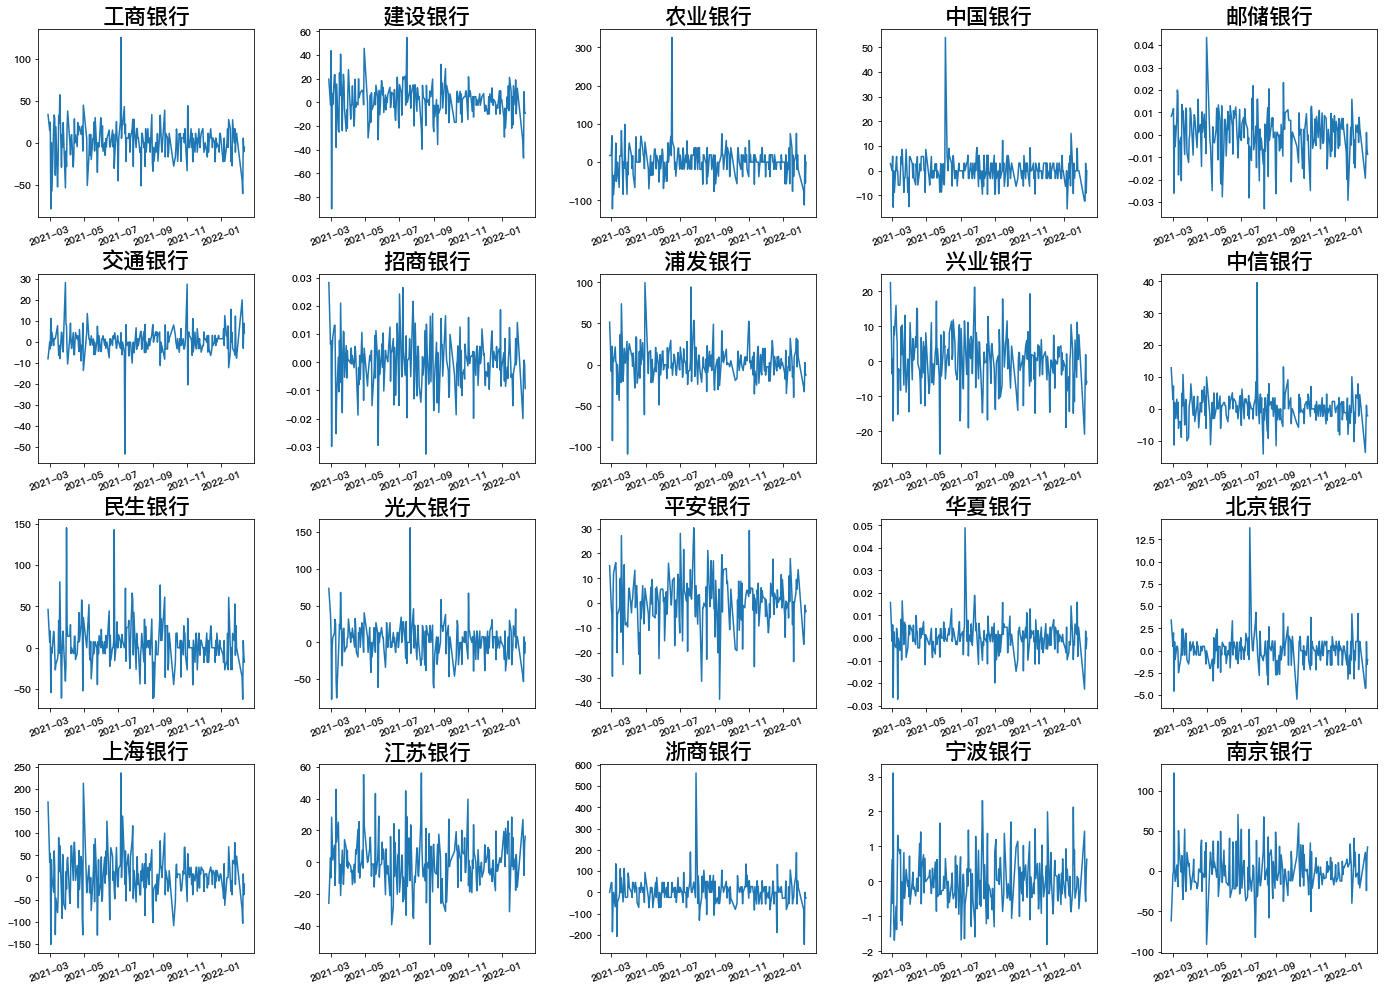

In [27]:
plt.figure(figsize=(24,17))
plt.subplots_adjust(hspace=0.3,wspace=0.3)
for i in range(1,len(X_covar_expand.columns)+1):
    plt.subplot(4,5,i)
    plt.plot(X_covar_expand.iloc[:,i-1])
    plt.xticks(rotation=20)
    plt.title(names[i-1],fontsize=22)

<AxesSubplot:>

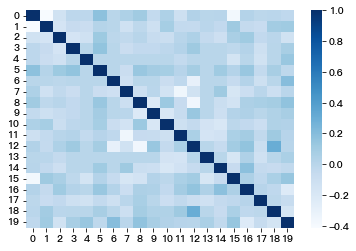

In [28]:
sns.heatmap(cor_covar,cmap='Blues')

<AxesSubplot:>

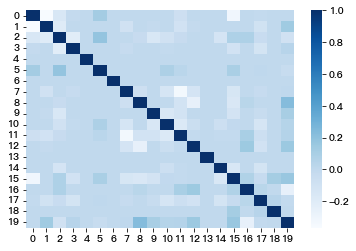

In [29]:
sns.heatmap(cor_cv_covar,cmap='Blues')

## 绘制网络图

In [32]:
G=nx.Graph(label='CoVaR')#添加图的属性
G.add_nodes_from([(symbols[i],{'name':names[i]}) for i in range(20)])#添加节点时，顺道添加节点的属性
G.add_edges_from([(symbols[i],symbols[j],{'weight':cor_covar[i][j]}) for i in range(20) for j in range(i+1,20)])#添加边时，顺道添加边的属性

In [33]:
G.graph#查看图的属性

{'label': 'CoVaR'}

In [34]:
G.nodes.data()#查看节点的属性

NodeDataView({'601398': {'name': '工商银行'}, '601939': {'name': '建设银行'}, '601288': {'name': '农业银行'}, '601988': {'name': '中国银行'}, '601658': {'name': '邮储银行'}, '601328': {'name': '交通银行'}, '600036': {'name': '招商银行'}, '600000': {'name': '浦发银行'}, '601166': {'name': '兴业银行'}, '601998': {'name': '中信银行'}, '600016': {'name': '民生银行'}, '601818': {'name': '光大银行'}, '000001': {'name': '平安银行'}, '600015': {'name': '华夏银行'}, '601169': {'name': '北京银行'}, '601229': {'name': '上海银行'}, '600919': {'name': '江苏银行'}, '601916': {'name': '浙商银行'}, '002142': {'name': '宁波银行'}, '601009': {'name': '南京银行'}})

In [35]:
list(G.edges.data())[0]#查看边的属性

('601398', '601939', {'weight': -0.4128703423181621})

In [36]:
elarge=[(i,j,w) for (i,j,w) in G.edges.data() if w['weight']>=0]
esmall=[(i,j,w) for (i,j,w) in G.edges.data() if w['weight']<0]

In [37]:
def plotNet(cor_data):
    G=nx.Graph()#添加图的属性
    G.add_nodes_from([(symbols[i],{'name':names[i]}) for i in range(20)])#添加节点时，顺道添加节点的属性
    G.add_edges_from([(symbols[i],symbols[j],{'weight':cor_data[i][j]}) for i in range(20) for j in range(i+1,20)])#添加边时，顺道添加边的属性

    seed=128
    elarge=[(i,j,w) for (i,j,w) in G.edges.data() if w['weight']>=0]#区分相关系数的正负
    esmall=[(i,j,w) for (i,j,w) in G.edges.data() if w['weight']<0]
    
    elarge_widths=[elarge[i][2]['weight'] for i in range(len(elarge))]
    esmall_widths=[esmall[i][2]['weight'] for i in range(len(esmall))]

    pos=nx.spring_layout(G,seed=seed,weight=1)

    nx.draw_networkx_nodes(G,pos,node_color='black',node_size=20)
    node_labels=nx.get_node_attributes(G,'name')
    nx.draw_networkx_labels(G,pos,node_labels,horizontalalignment='center',verticalalignment='bottom')

    nx.draw_networkx_edges(
        G,
        pos,
        #style='dashed',
        edgelist=elarge,
        width=2*np.array(elarge_widths),
    )
    nx.draw_networkx_edges(
        G,
        pos,
        edgelist=esmall,
        width=2*np.array(esmall_widths),
        #style="dashed"
    )

In [38]:
edge_widths=[list(G.edges.data())[i][2]['weight'] for i in range(G.number_of_edges())]

networkx.spring_layout(G)使用FR算法来确定节点的位置，weight参数用来确定边的权重，默认weight='weight'，故方便起见，在设置边的权重时，可将权重名称设置为'weight'。

The edge attribute that holds the numerical value used for the edge weight. If None, then all edge weights are 1.

In [39]:
def plotNet(cor_data):
    G=nx.Graph()#添加图的属性
    G.add_nodes_from([(symbols[i],{'name':names[i]}) for i in range(20)])#添加节点时，顺道添加节点的属性
    G.add_edges_from([(symbols[i],symbols[j],{'weight':cor_data[i][j]}) for i in range(20) for j in range(i+1,20)])#添加边时，顺道添加边的属性

    cmap = plt.cm.plasma
    seed=128
    pos=nx.spring_layout(G,seed=seed,weight=1)
    edge_widths=[list(G.edges.data())[i][2]['weight'] for i in range(G.number_of_edges())]
    edge_color=[]
    for weight in edge_widths:
        if weight>=0:
            edge_color.append('y')
        else:
            edge_color.append('b')

    nodes=nx.draw_networkx_nodes(G,pos,node_color='black',node_size=20)
    node_labels=nx.get_node_attributes(G,'name')
    nx.draw_networkx_labels(G,pos,node_labels,horizontalalignment='center',verticalalignment='bottom')
    edges=nx.draw_networkx_edges(
        G,
        pos,
        edge_color='k',
        width=3*np.array(edge_widths),
    )
def calDensity(cor_cv_data):
    density=(cor_cv_data==0).sum()
    sys=np.abs(cor_cv_data).sum()-20
    print('图的密度为：',(1-density/19/19).round(4))
    print('系统性金融风险为：',sys.round(2))

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


图的密度为： 0.4349
系统性金融风险为： 9.67


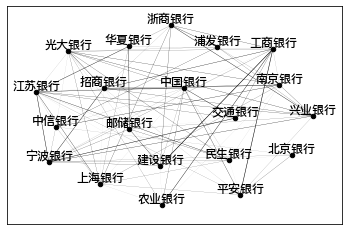

In [40]:
calDensity(cor_cv_text)
plotNet(cor_cv_text)

图的密度为： 0.4404
系统性金融风险为： 13.63


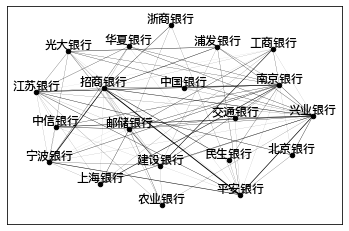

In [41]:
calDensity(cor_cv_market)
plotNet(cor_cv_market)

图的密度为： 0.385
系统性金融风险为： 15.17


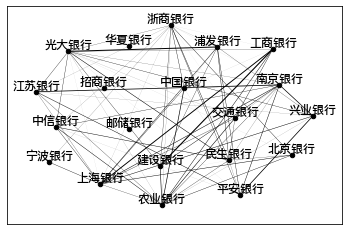

In [42]:
calDensity(cor_cv_covar)
plotNet(cor_cv_covar)

热力图

([<matplotlib.axis.YTick at 0x2992bce20>,
 [Text(0, 0, '工商银行'),
  Text(0, 1, '建设银行'),
  Text(0, 2, '农业银行'),
  Text(0, 3, '中国银行'),
  Text(0, 4, '邮储银行'),
  Text(0, 5, '交通银行'),
  Text(0, 6, '招商银行'),
  Text(0, 7, '浦发银行'),
  Text(0, 8, '兴业银行'),
  Text(0, 9, '中信银行'),
  Text(0, 10, '民生银行'),
  Text(0, 11, '光大银行'),
  Text(0, 12, '平安银行'),
  Text(0, 13, '华夏银行'),
  Text(0, 14, '北京银行'),
  Text(0, 15, '上海银行'),
  Text(0, 16, '江苏银行'),
  Text(0, 17, '浙商银行'),
  Text(0, 18, '宁波银行'),
  Text(0, 19, '南京银行')])

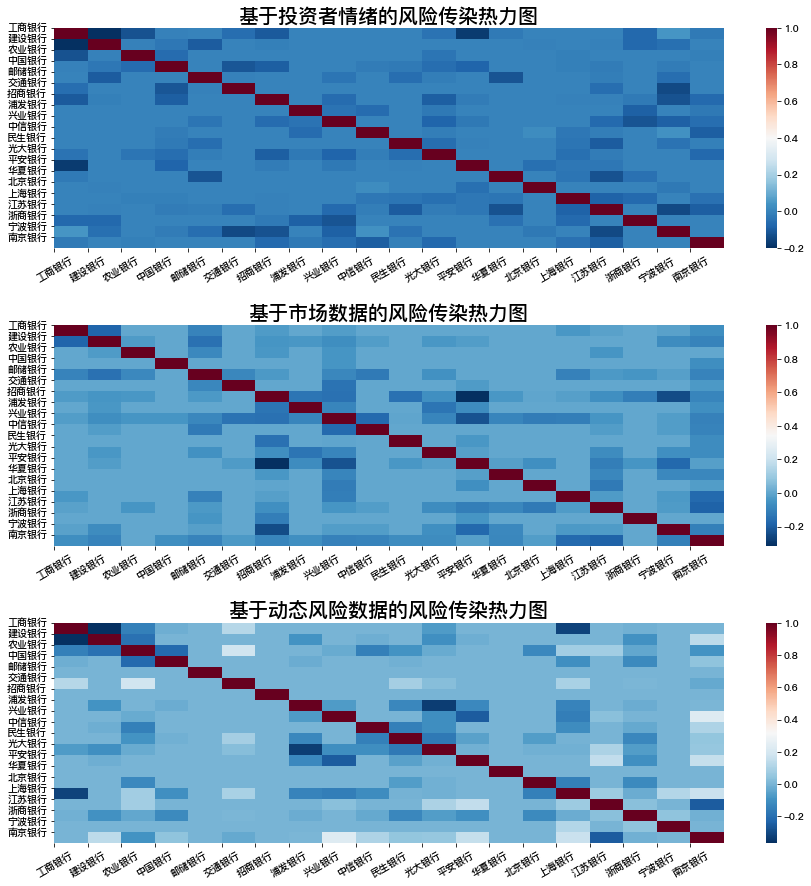

In [64]:
plt.figure(figsize=(15,15))
plt.subplots_adjust(hspace=0.35)
plt.subplot(311)
sns.heatmap(cor_cv_text,cmap='RdBu_r')
plt.title('基于投资者情绪的风险传染热力图',fontsize=20)
plt.xticks(np.arange(20),names,rotation=30)
plt.yticks(np.arange(20),names,rotation=360)

plt.subplot(312)
sns.heatmap(cor_cv_market,cmap='RdBu_r')
plt.title('基于市场数据的风险传染热力图',fontsize=20)
plt.xticks(np.arange(20),names,rotation=30)
plt.yticks(np.arange(20),names,rotation=360)

plt.subplot(313)
sns.heatmap(cor_cv_covar,cmap='RdBu_r')
plt.title('基于动态风险数据的风险传染热力图',fontsize=20)
plt.xticks(np.arange(20),names,rotation=30)
plt.yticks(np.arange(20),names,rotation=360)

单个银行机构的风险传染能力。

In [44]:
cor_cv_all=np.abs(cor_cv_text)+np.abs(cor_cv_market)+np.abs(cor_cv_covar)
cor_cv_all=pd.DataFrame(cor_cv_all.sum(axis=1))
cor_cv_all.index=names
cor_cv_all.sort_values(by=0,ascending=False).round(2)

,0
南京银行,6.30
兴业银行,6.10
上海银行,5.49
平安银行,5.45
工商银行,5.40
光大银行,5.38
江苏银行,5.37
建设银行,5.27
招商银行,5.14
农业银行,4.94


外溢性、稳定性和系统重要性指标

In [46]:
values=[]
for symbol in symbols:
    info=ak.stock_individual_info_em(symbol=symbol)
    value=info['value'][info['item']=='总市值'].item()
    values.append(value)

values=np.array(values)
values

array([1.67510941e+12, 1.52006674e+12, 1.04994910e+12, 9.21433787e+11,
       5.22893257e+11, 3.62402106e+11, 1.24762576e+12, 2.47145255e+11,
       4.58278648e+11, 2.26568321e+11, 1.71189256e+11, 1.81547254e+11,
       3.04284797e+11, 8.69378155e+10, 9.57777188e+10, 9.95885260e+10,
       1.00876565e+11, 7.33770039e+10, 2.51662845e+11, 1.00371105e+11])

In [47]:
def calIndex(cor_cv_data):
    index=pd.DataFrame(np.zeros((20,20)))
    
    for i in range(20):
        for j in range(20):
            index.iloc[i,j]=cor_cv_data[i][j]*(values[i]+values[j])
    for i in range(20):
        index.iloc[i,i]=0

    index=index/values.sum()
    index_df=pd.DataFrame([index[index>0].sum(axis=1),np.abs(index[index<0].sum(axis=1))])
    return index_df.T

In [48]:
index=calIndex(cor_cv_text)+calIndex(cor_cv_market)+calIndex(cor_cv_covar)
index.columns=['外溢性','稳定性']
index['系统重要性']=index['外溢性']+index['稳定性']
index.index=names
index=index.round(3)

In [49]:
index['稳定性'].sort_values(ascending=False)

工商银行    0.575
建设银行    0.530
招商银行    0.365
农业银行    0.306
兴业银行    0.242
平安银行    0.195
中国银行    0.178
邮储银行    0.165
光大银行    0.159
宁波银行    0.140
上海银行    0.132
南京银行    0.132
浦发银行    0.117
浙商银行    0.107
中信银行    0.080
民生银行    0.080
江苏银行    0.072
交通银行    0.065
北京银行    0.039
华夏银行    0.034
Name: 稳定性, dtype: float64

In [ ]:
(index['稳定性']/index['系统重要性']).mean()

0.9073242064506692